In [1]:
# proxy
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import json
from PIL import Image

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
device = torch.device('cuda')

In [5]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis('off')
    return image

def normalize(image):
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Variable(preprocess(image).unsqueeze(0).cuda())
    return img

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

In [7]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [8]:
# modulelist = list(vgg.features.modules())

In [9]:
def visualize(image):
    img = normalize(image)
    img.requires_grad_()
    
    vgg.eval()
    out = vgg(img)
    
    vgg.zero_grad()
    acc, label = out.squeeze(0).max(0)
    label = label.reshape(1)
    
    out[0][label].backward()
    
    grad = img.grad.squeeze()
    grad.abs_()
    grad.clamp_(min=0)
    grad = grad.max(dim=0, keepdim=True)[0]
    grad = grad / grad.max()
    
    vmap = torchvision.utils.make_grid(grad.cpu()).numpy()
    vmap = np.transpose(vmap, (1,2,0))
    vmap = np.clip(vmap, 0, 1)

    inimg = normalize(image)
    inimg.squeeze_(0)
    inimg = inimg.cpu().numpy()
    inimg = np.transpose(inimg, (1,2,0))
    inimg = np.clip(inimg, 0, 1)

    plt.figure(figsize=(16,12))
    plt.subplot(1,2,1)
    plt.imshow(inimg)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(vmap)
    plt.axis('off')
    
    return vmap

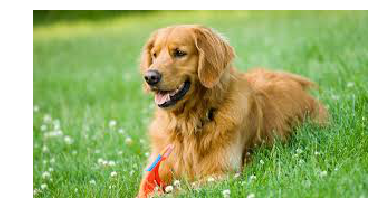

In [10]:
img = load_image('images/retr.jpg')

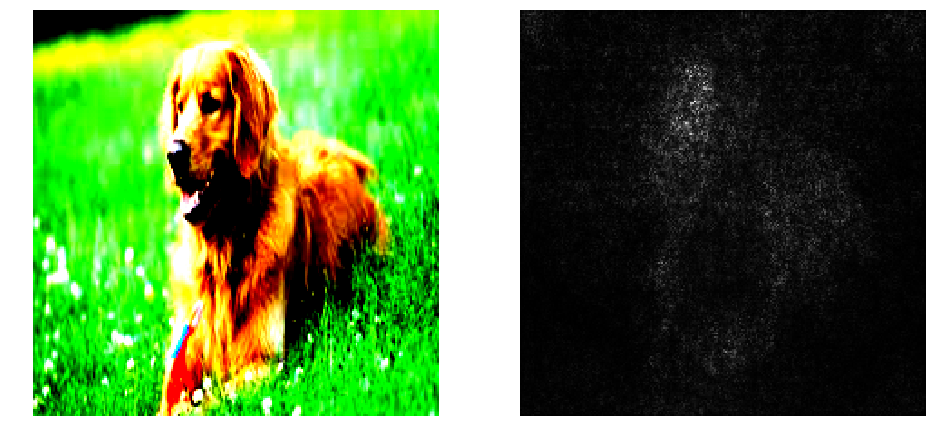

In [11]:
vis = visualize(img)